In [56]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
import tabulate
import itertools
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from collections import Counter
import umap
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
import goatools
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
from sklearn import metrics
from sklearn.decomposition import PCA
import tabulate
import itertools
import igraph as ig
import matplotlib.patches as mpatches
from sklearn.neighbors import radius_neighbors_graph
from scipy.ndimage import gaussian_filter1d
from sklearn.neighbors import kneighbors_graph
from scipy.spatial.distance import pdist, squareform
import leidenalg as la
import dask.array as da
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import umap
import bbknn
import bbknn.matrix
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
import gget
import gget

# locals
import utils as ut
reload(ut)

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
clusterPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/clusters.csv"
cf = pd.read_parquet(clusterPath)
print(cf.shape)
print(cf['cellType'].unique())
cf.head()

(427882, 7)
['Macrophages' 'B cells' 'Monocytes' 'NK cells' 'Dendritic cells'
 'T cells' 'Stromal cells']


gene     scores          pvals  logfoldchanges  clusterId key  \
0  H2-EB1  36.343353  4.575346e-181        3.564091          1  ND   
1   H2-AA  35.311523  4.761517e-183        3.430534          1  ND   
2  H2-AB1  34.411163  2.815112e-177        3.234597          1  ND   
3    CD74  33.910587  2.451588e-177        3.302062          1  ND   
4  H2-DMA  31.695400  2.991793e-123        2.667091          1  ND   

      cellType  
0  Macrophages  
1  Macrophages  
2  Macrophages  
3  Macrophages  
4  Macrophages

In [3]:
"""load scRNA"""
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

rna = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        rna[key] = data
    
print("done")

done


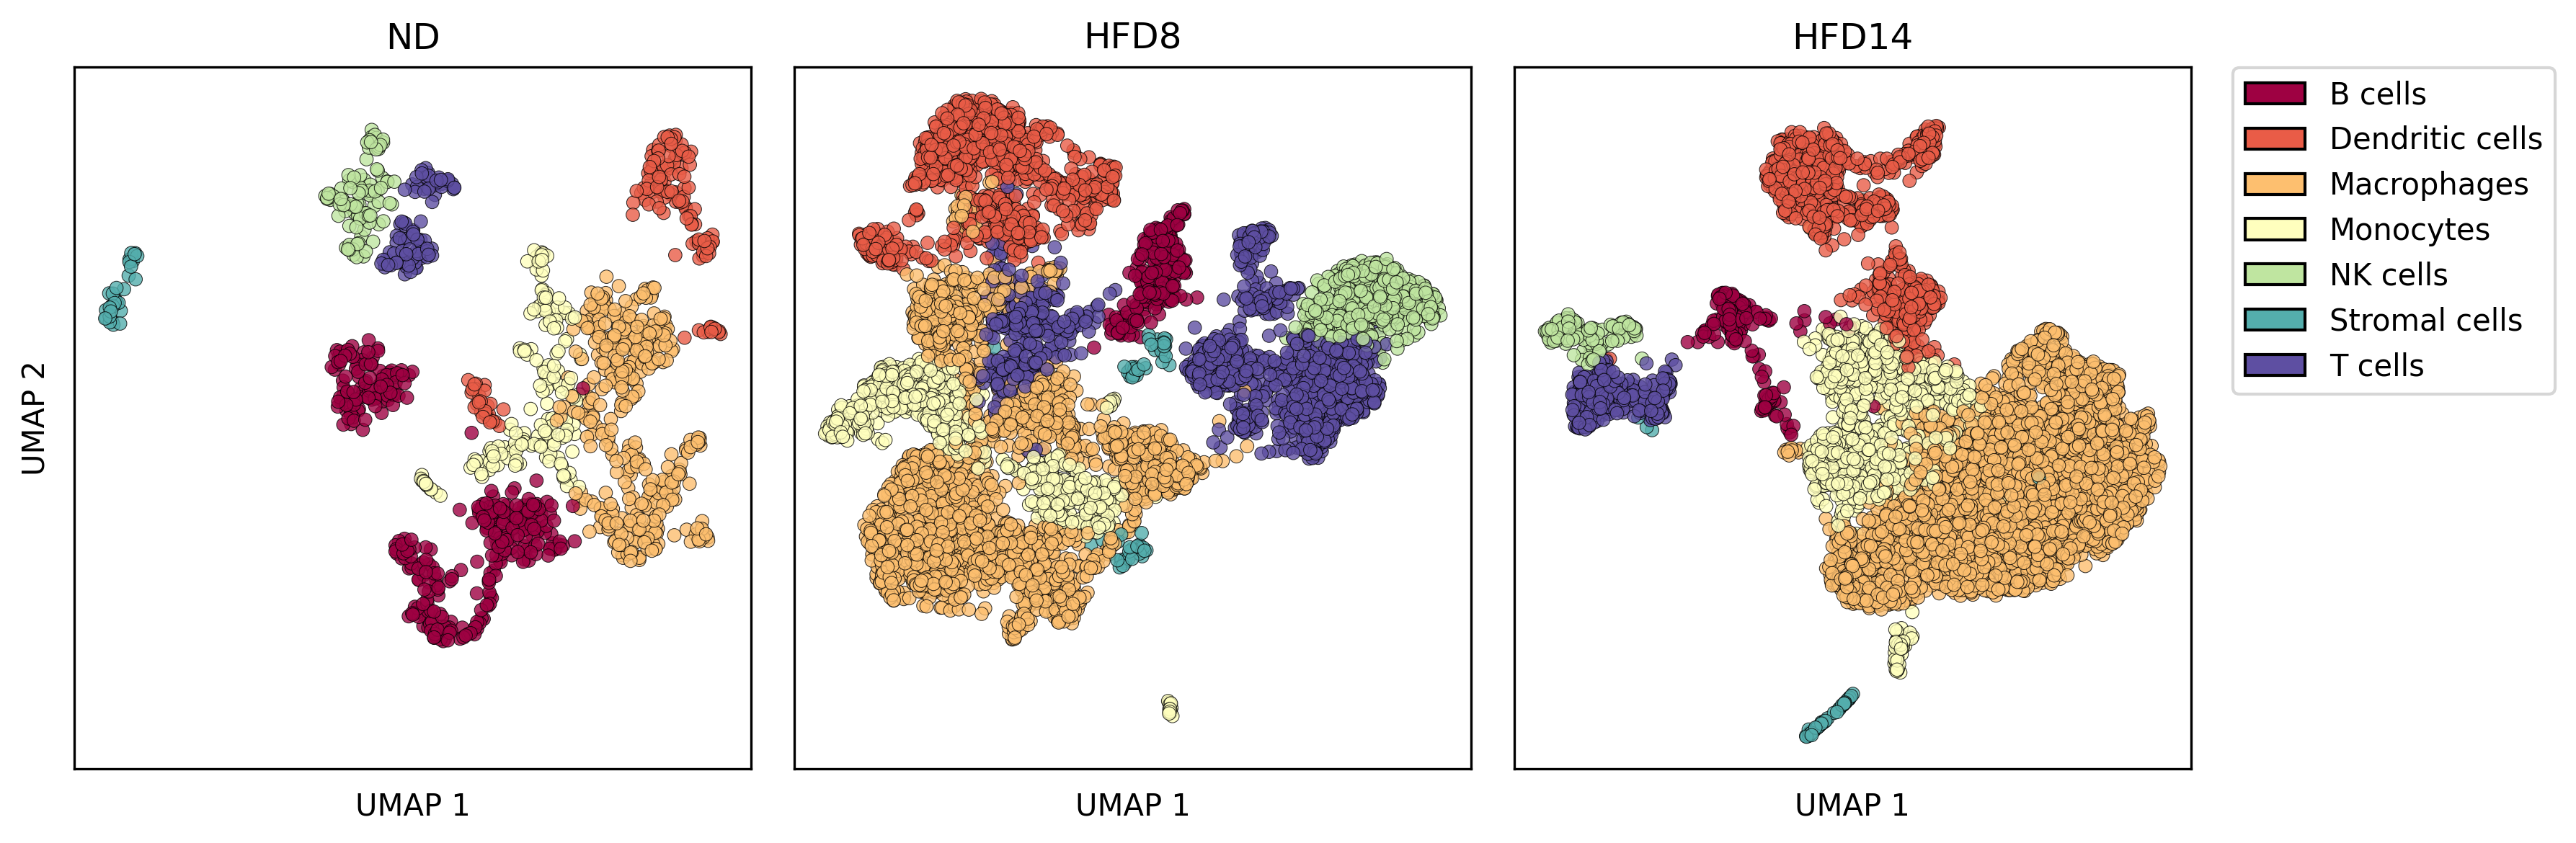

In [109]:
# plot clusters using individual embeddings
# shows how well defined the clusters are at a single time point
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = 'w'

keys = ['ND', 'HFD8', 'HFD14']

ncolors = cf['cellType'].nunique()
ctypes = sorted(cf['cellType'].unique())

colordict = dict(zip(ctypes, ut.ncolor(ncolors, cmap='Spectral')))

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()


for i, key in enumerate(keys):
    data = rna[key]
        
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    embedding = data.obsm['X_umap']
    
    # get coloring
    c = ['k'] * len(embedding)
    handles = []
    
    for ctype in ctypes:
        mask = (cf['cellType'] == ctype) & (cf['key'] == key)
        cids = cf[mask]['clusterId'].unique()
        c = np.where(clusterIds.isin(cids), colordict[ctype], c)
        
        handle = mpatches.Patch(color=colordict[ctype], 
                                ec='k', 
                                label=ctype)
        handles.append(handle)
        
    
    axs[i].scatter(embedding[:, 0] , 
                   embedding[:, 1] , 
                   c=c,
                   edgecolor="k",
                   linewidth=0.25,
                   s=20,
                   alpha=0.8,)
    
        
    axs[i].set_title(key)
    axs[i].set_xlabel("UMAP 1")
    
    if i == 0:
        axs[i].set_ylabel("UMAP 2")
    
    _ = axs[i].set_xticks([])
    _ = axs[i].set_yticks([])

    
plt.legend(handles=handles, bbox_to_anchor=(1.04, 1.02))
plt.tight_layout()

['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2']

['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2']

['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2']



cellType  proportion    color key
0          B cells    0.287074  #9e0142  ND
1  Dendritic cells    0.113402  #e95c47  ND
2      Macrophages    0.284695  #fdbf6f  ND
3        Monocytes    0.138779  #ffffbe  ND
4         NK cells    0.076130  #bfe5a0  ND

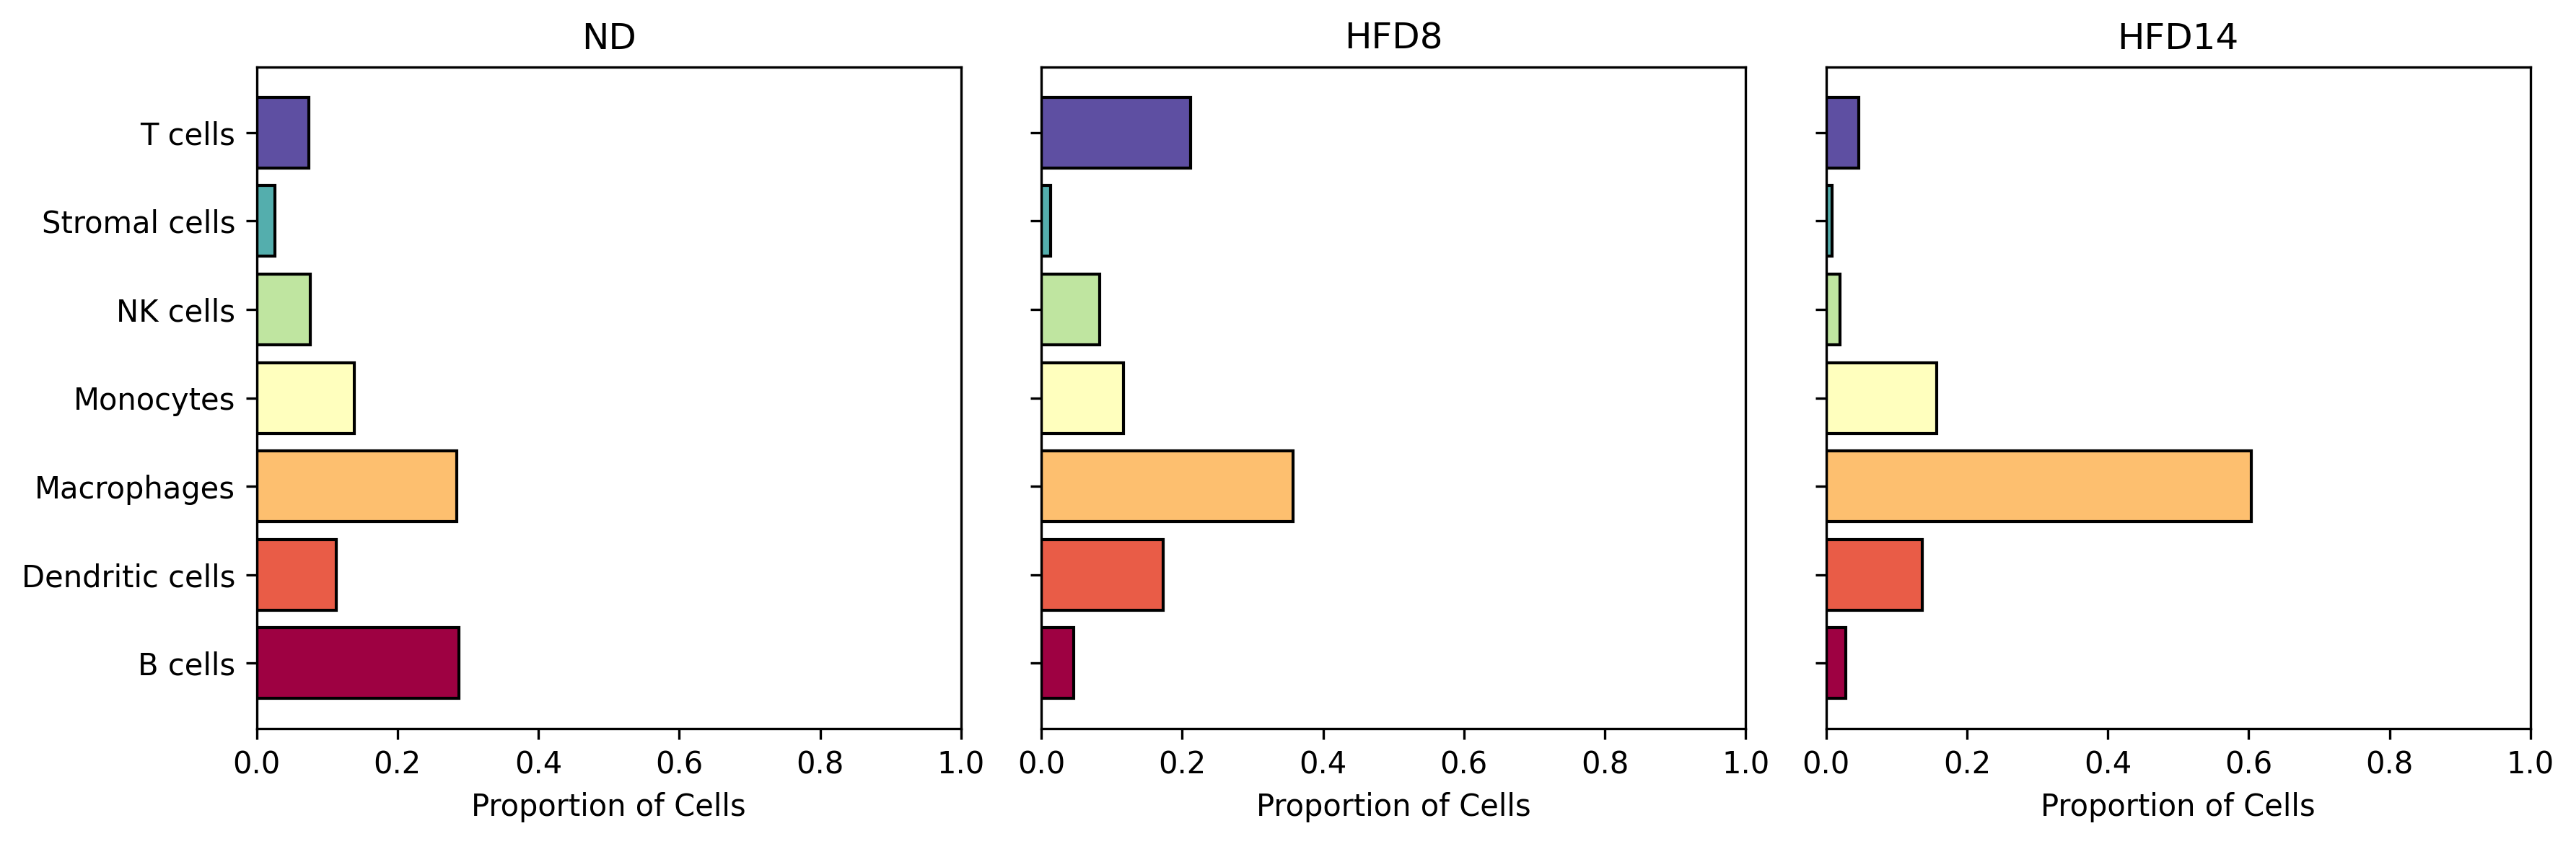

In [5]:
keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = 'w'


keys = ['ND', 'HFD8', 'HFD14']

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()

res = []

for i, key in enumerate(keys):
    data = rna[key]
    
    clusterCount = pd.DataFrame(data.obs[runKey].astype(int).value_counts(normalize=True))
    clusterCount.columns = ['proportion'] 
    clusterCount['clusterId'] = clusterCount.index + 1
    
    # add cell types
    mask = (cf['key'] == key)
    ctdf = cf[mask]
    
    ctdf = ctdf.drop_duplicates(subset=['cellType', 'clusterId'])
    ctMapper = dict(zip(ctdf['clusterId'], ctdf['cellType']))
    
    clusterCount['cellType'] = clusterCount['clusterId'].map(ctMapper)
    
    grped = clusterCount.groupby('cellType')['proportion'].sum()
    grped = grped.sort_index(ascending=False).reset_index()
    
    grped['color'] = grped['cellType'].map(colordict)
    grped['key'] = key
    
    grped = grped.sort_values(by='cellType')
    print(grped['color'].to_list())
    print()
    
    res.append(grped)
    
    axs[i].barh(grped['cellType'],
             grped['proportion'],
             color=grped['color'],
             edgecolor='k')
    
    axs[i].set_xlabel('Proportion of Cells')
    axs[i].set_title(key)
    axs[i].set_xlim([0, 1])

plt.tight_layout()


res = pd.concat(res,ignore_index=True)
res.head()

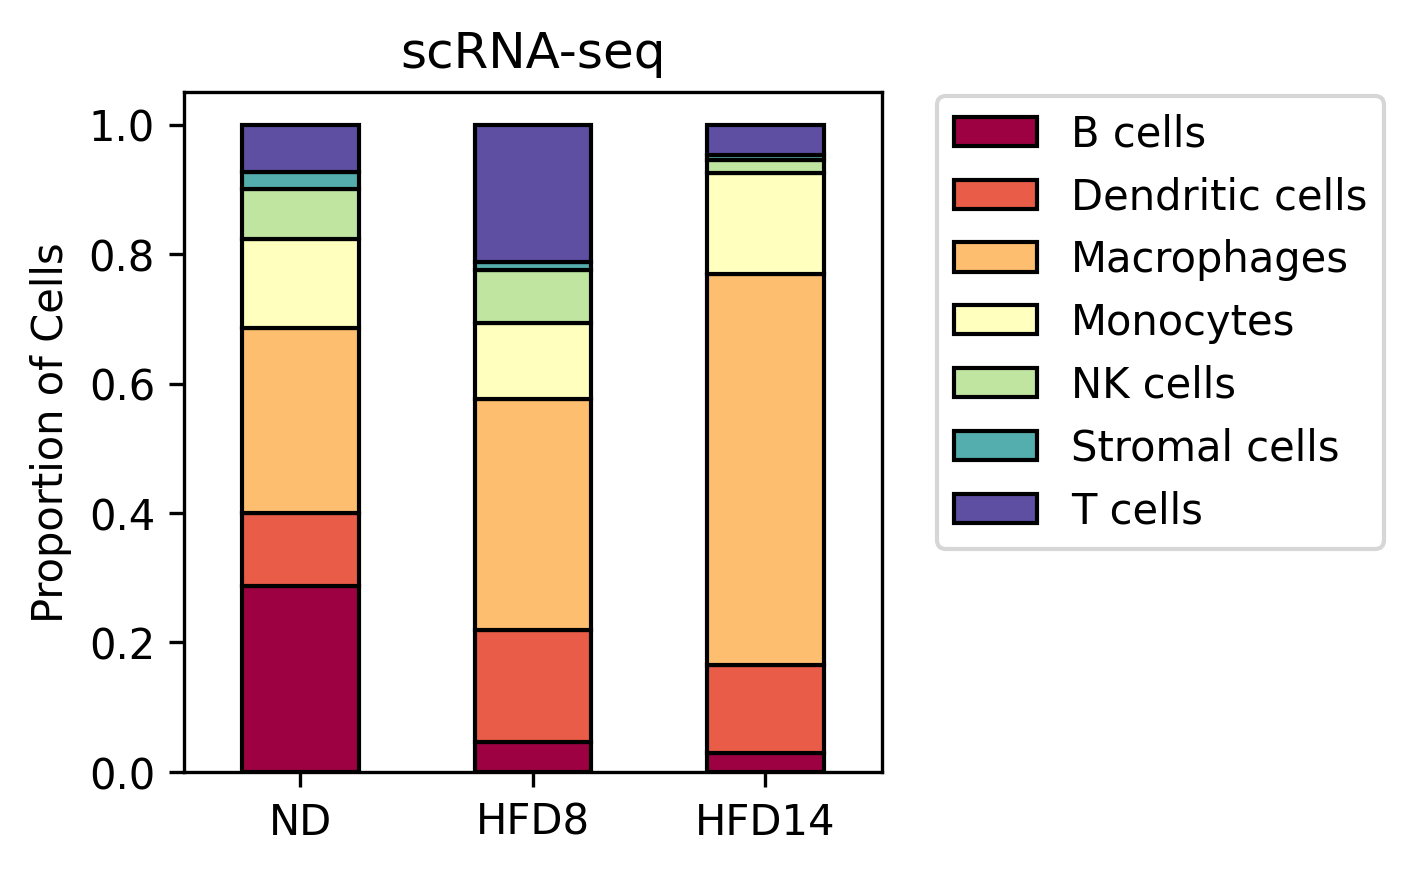

In [6]:
res = res.sort_values(by='key', ascending=False)
res2 = pd.pivot_table(res, values='proportion', index=['cellType'], columns='key').reset_index()
res2 = res2.set_index('cellType')
# res2.columns = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = 'w'

# res = res.set_index('cellType')
res2.T.plot(kind='bar', stacked=True, edgecolor='k', color=['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2'])
plt.legend(bbox_to_anchor=(1.05, 1.025))
plt.ylabel('Proportion of Cells')
_ = plt.xticks(rotation=0)
plt.xlabel("")
plt.title("scRNA-seq")
plt.gca().invert_xaxis()

In [82]:
""" a pooled approach """

allGenes = []
clusterIdList = []
colors = []
cellTypes = []


for i, key in enumerate(keys):
    data = rna[key]
    df = data.to_df()
    allGenes += df.columns.to_list()
    
    allKeys = list(data.obs.keys())
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    clusterIdList += list(clusterIds)
    
    # get coloring
    c = ['k'] * len(df)
    cellType = ['NULL'] * len(df)
    handles = []
    
    for ctype in ctypes:
        mask = (cf['cellType'] == ctype) & (cf['key'] == key)
        cids = cf[mask]['clusterId'].unique()
        c = np.where(clusterIds.isin(cids), colordict[ctype], c)
        cellType = np.where(clusterIds.isin(cids), ctype, cellType)
        
    colors += list(c)
    cellTypes += list(cellType)
    

    # only consider genes present at all time points
allGenes = [k for (k,v) in Counter(allGenes).items() if v > 2]

keyVector = []
dfList = []

for i, key in enumerate(keys):
    data = rna[key]
    df = data.to_df()
    df = df[allGenes]
    
    keyVector += ([key] * df.shape[0])
    dfList.append(df)

X = pd.concat(dfList, ignore_index=True)
X = X.to_numpy()

""" PCA """
r = 10
pca = PCA(n_components=r)
pcaModel = pca.fit(X)
Xpca = pca.fit_transform(X)

""" UMAP """

# plotting params
n_components = 2 # should always be 2
n_neighbors = 50
min_dist = 0.25
metric= "euclidean"

umap_reducer = umap.UMAP(n_components=n_components,
                         n_neighbors=n_neighbors,
                         min_dist=min_dist,
                         metric=metric)

ef = umap_reducer.fit_transform(Xpca) # we need embedding by cell
ef = pd.DataFrame(ef)
ef.columns = ['x', 'y']
ef['key'] = keyVector
ef['clusterId'] = clusterIdList
ef['colors'] = colors
ef['cellTypes'] = cellTypes

print(ef['cellTypes'].value_counts(normalize=True))

Macrophages        0.465340
Dendritic cells    0.150724
Monocytes          0.137337
T cells            0.122287
B cells            0.059841
NK cells           0.052533
Stromal cells      0.011939
Name: cellTypes, dtype: float64


Text(0, 0.5, 'UMAP 2')

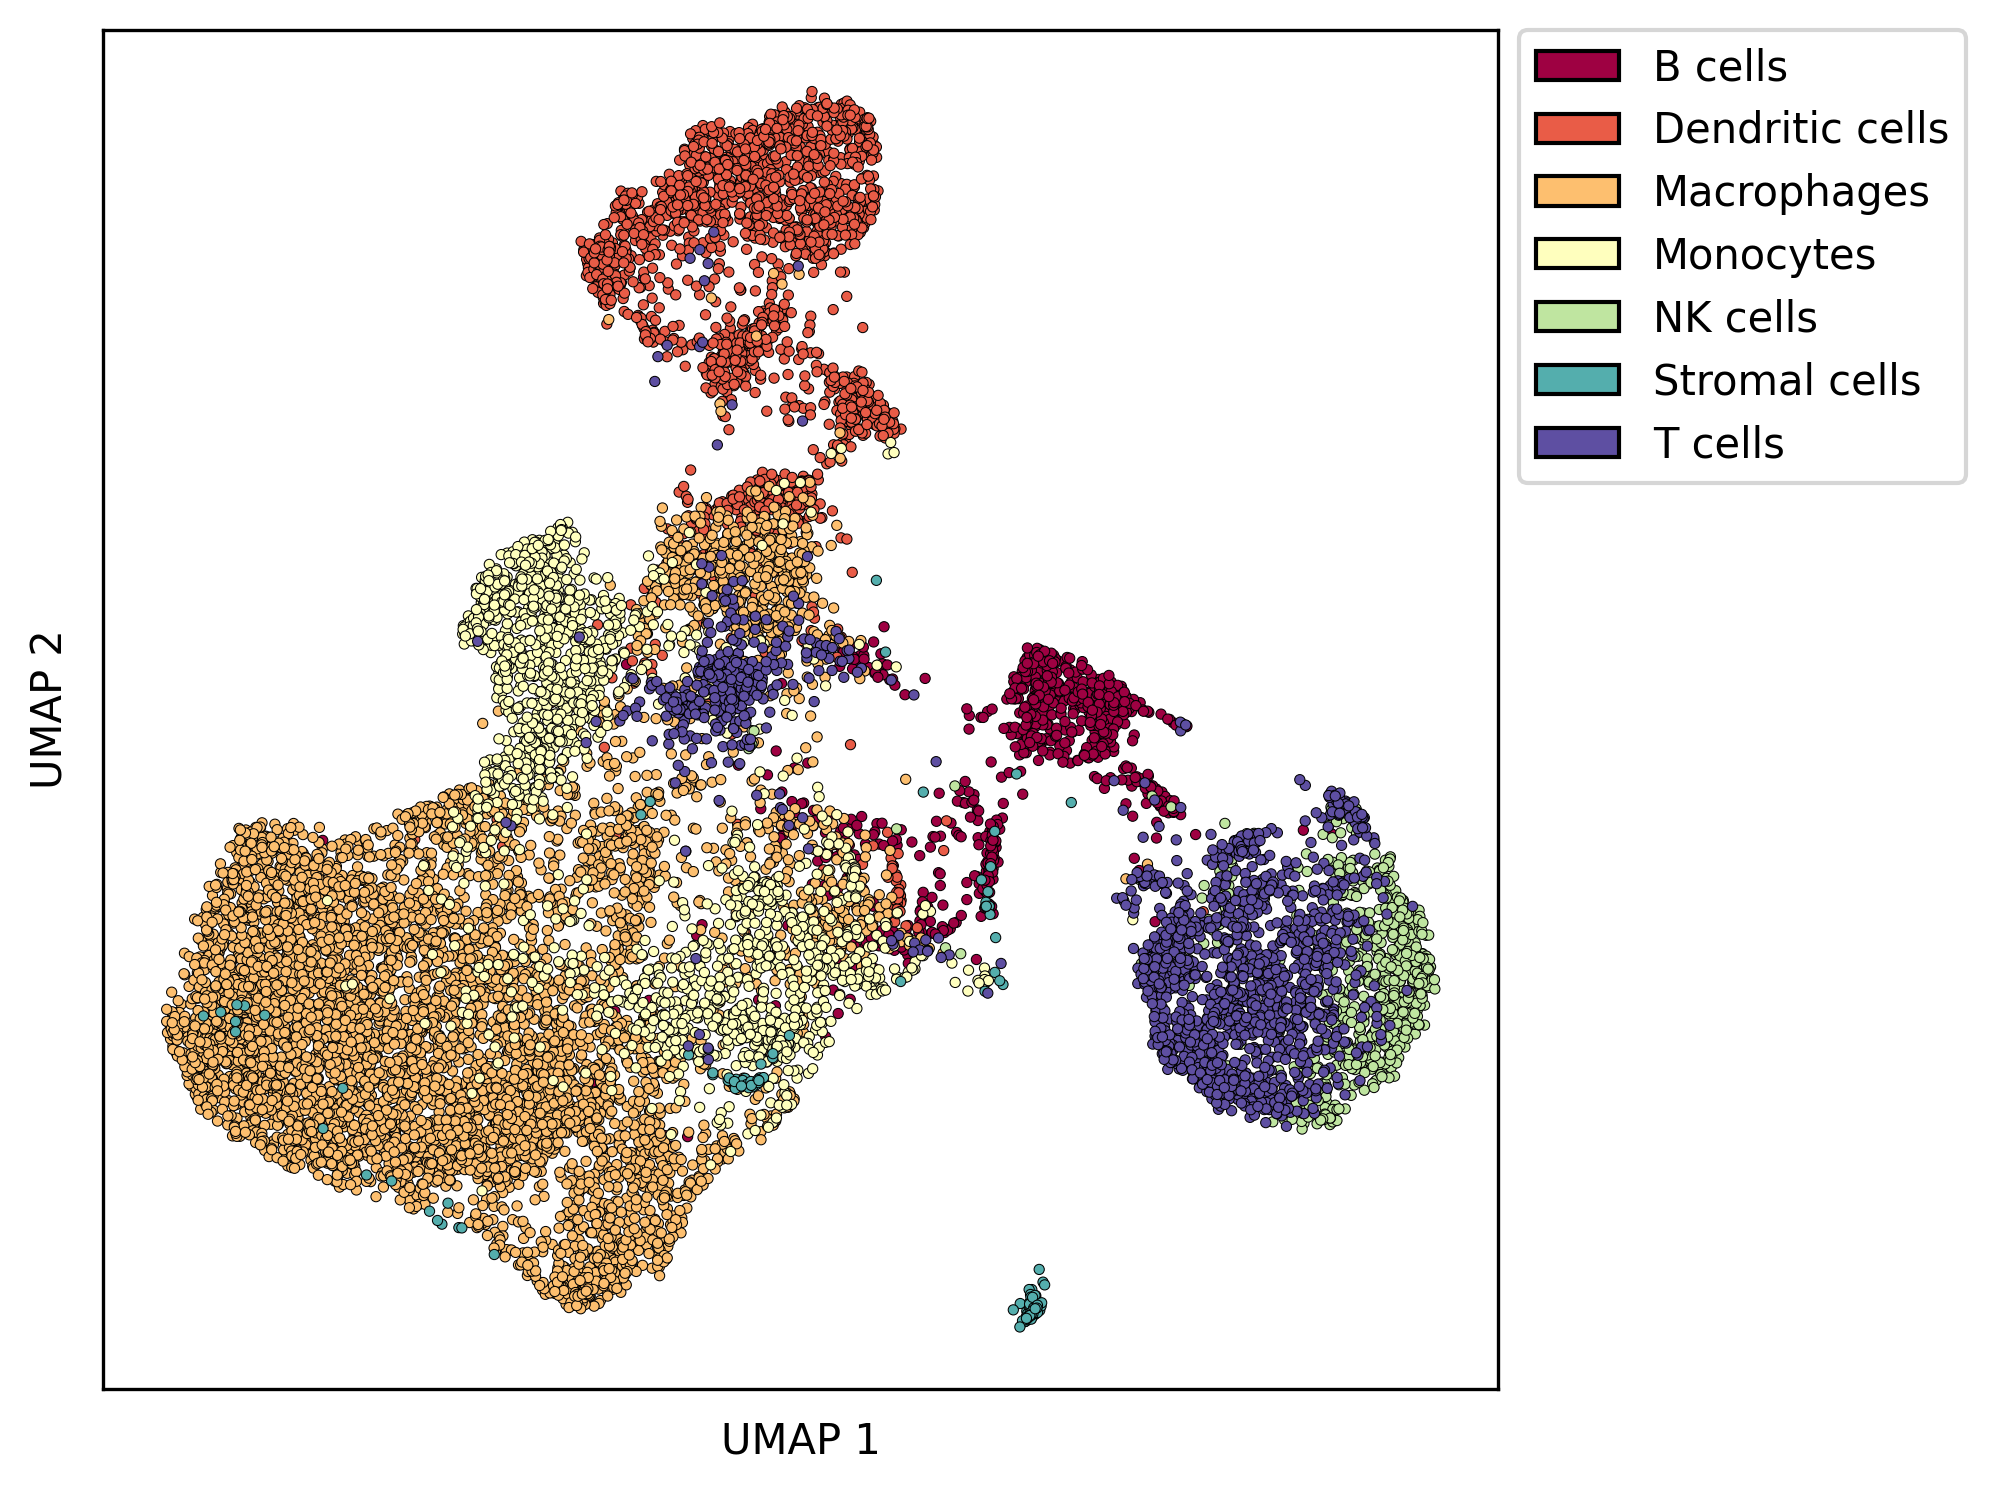

In [128]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = 'w'

pdf = ef.sort_values(by='cellTypes')

plt.scatter(pdf['x'], 
            pdf['y'], 
            ec='k', 
            lw=0.25,
            c=pdf['colors'],
            s=6)


plt.legend(handles=handles, bbox_to_anchor=(1.35, 1.015))
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

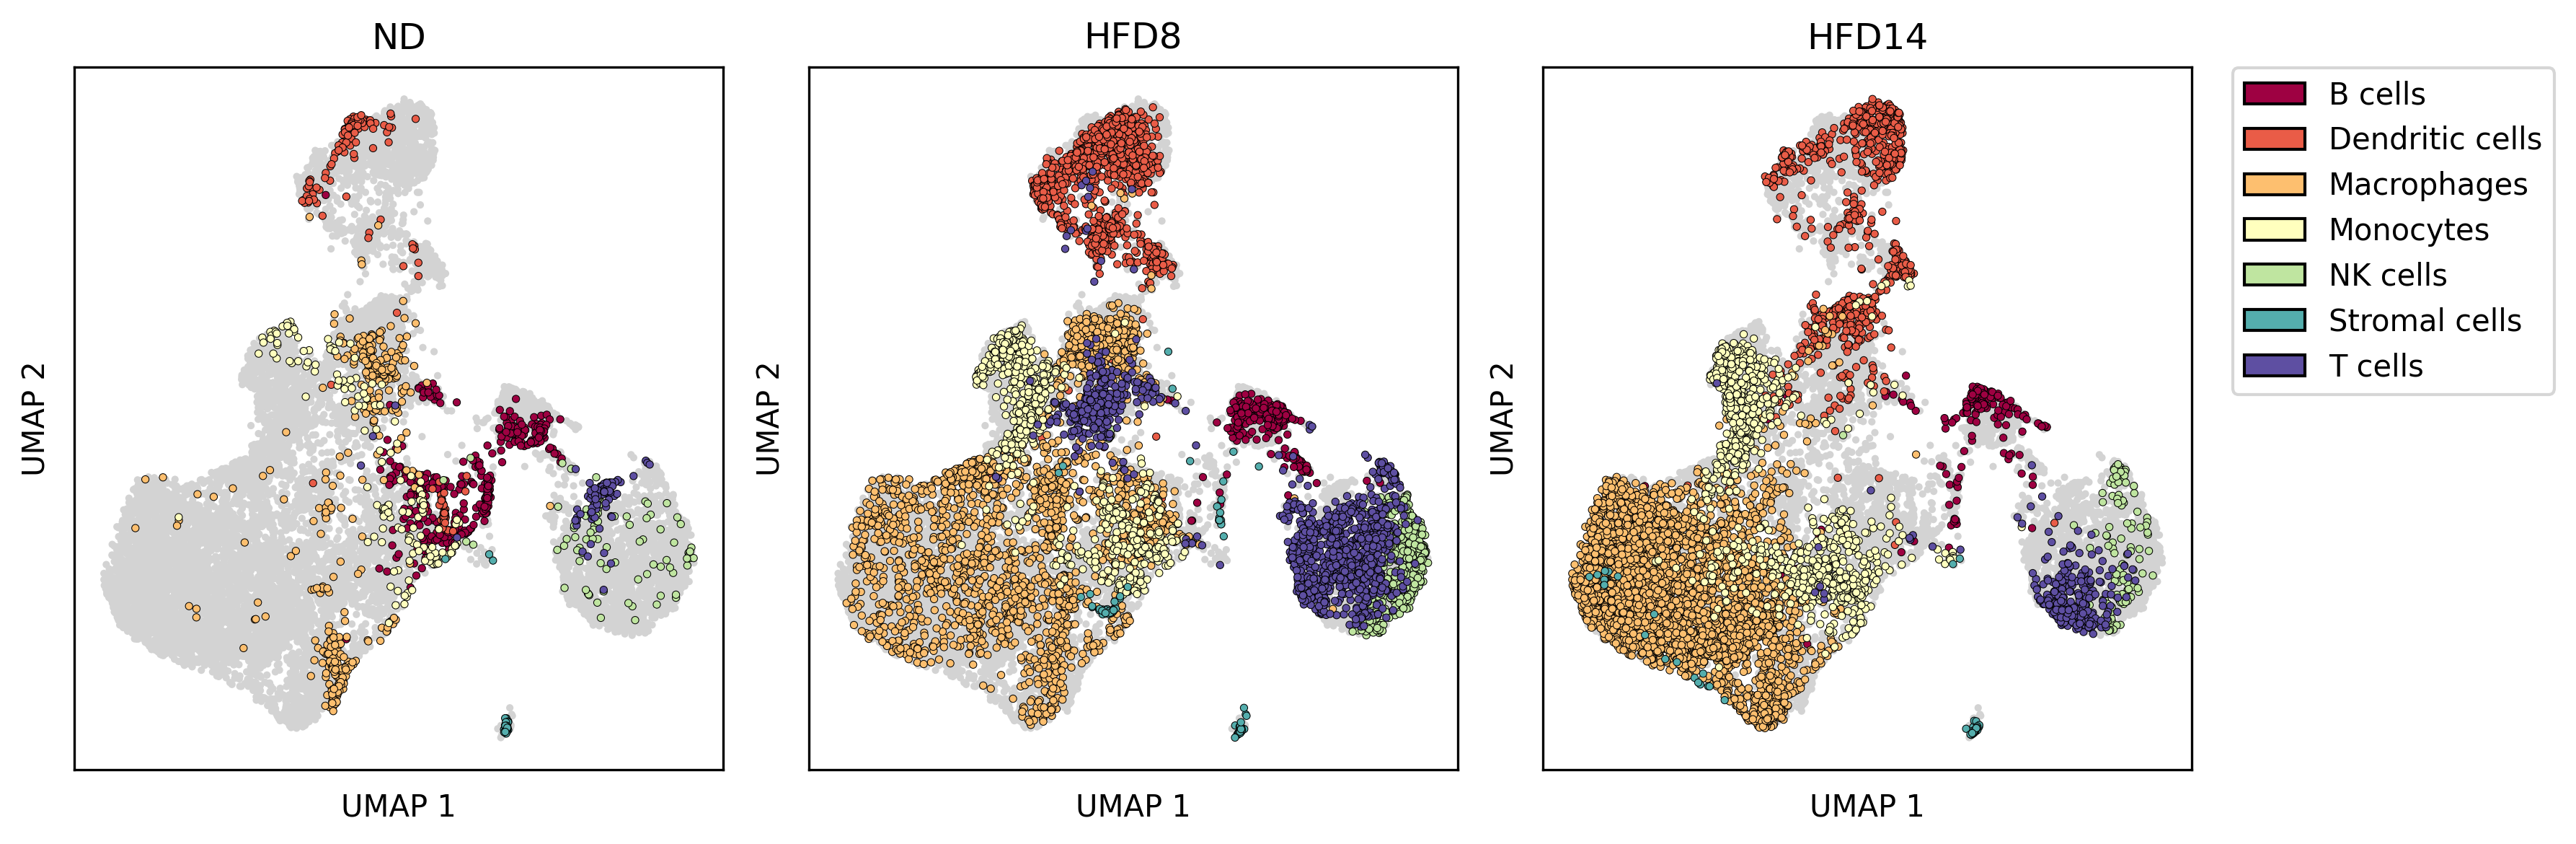

In [133]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = 'w'

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()

for i, key in enumerate(keys):

    mask = ef['key'] == key
    pdf = ef.sort_values(by='cellTypes')
    
    axs[i].scatter(pdf['x'][mask], 
                   pdf['y'][mask], 
                   ec='k', 
                   lw=0.25,
                   c=pdf['colors'][mask],
                   zorder=2,
                   s=6)
        
    axs[i].scatter(pdf['x'][~mask], 
                   pdf['y'][~mask], 
                   ec='None', 
                   lw=0.25,
                   c='lightgrey',
                   zorder=1,
                   s=6)

    axs[i].set_xlabel("UMAP 1")
    axs[i].set_ylabel("UMAP 2")
    axs[i].set_title(key)
    axs[i].set_xticks([], [])
    axs[i].set_yticks([], [])
    # axs[i].set_legend(title="")
    

plt.legend(handles=handles, bbox_to_anchor=(1.04, 1.02))
plt.tight_layout()

['B cells' 'Macrophages' 'Monocytes' 'T cells' 'NK cells' 'Stromal cells'
 'Dendritic cells']


Text(0, 0.5, 'UMAP 2')

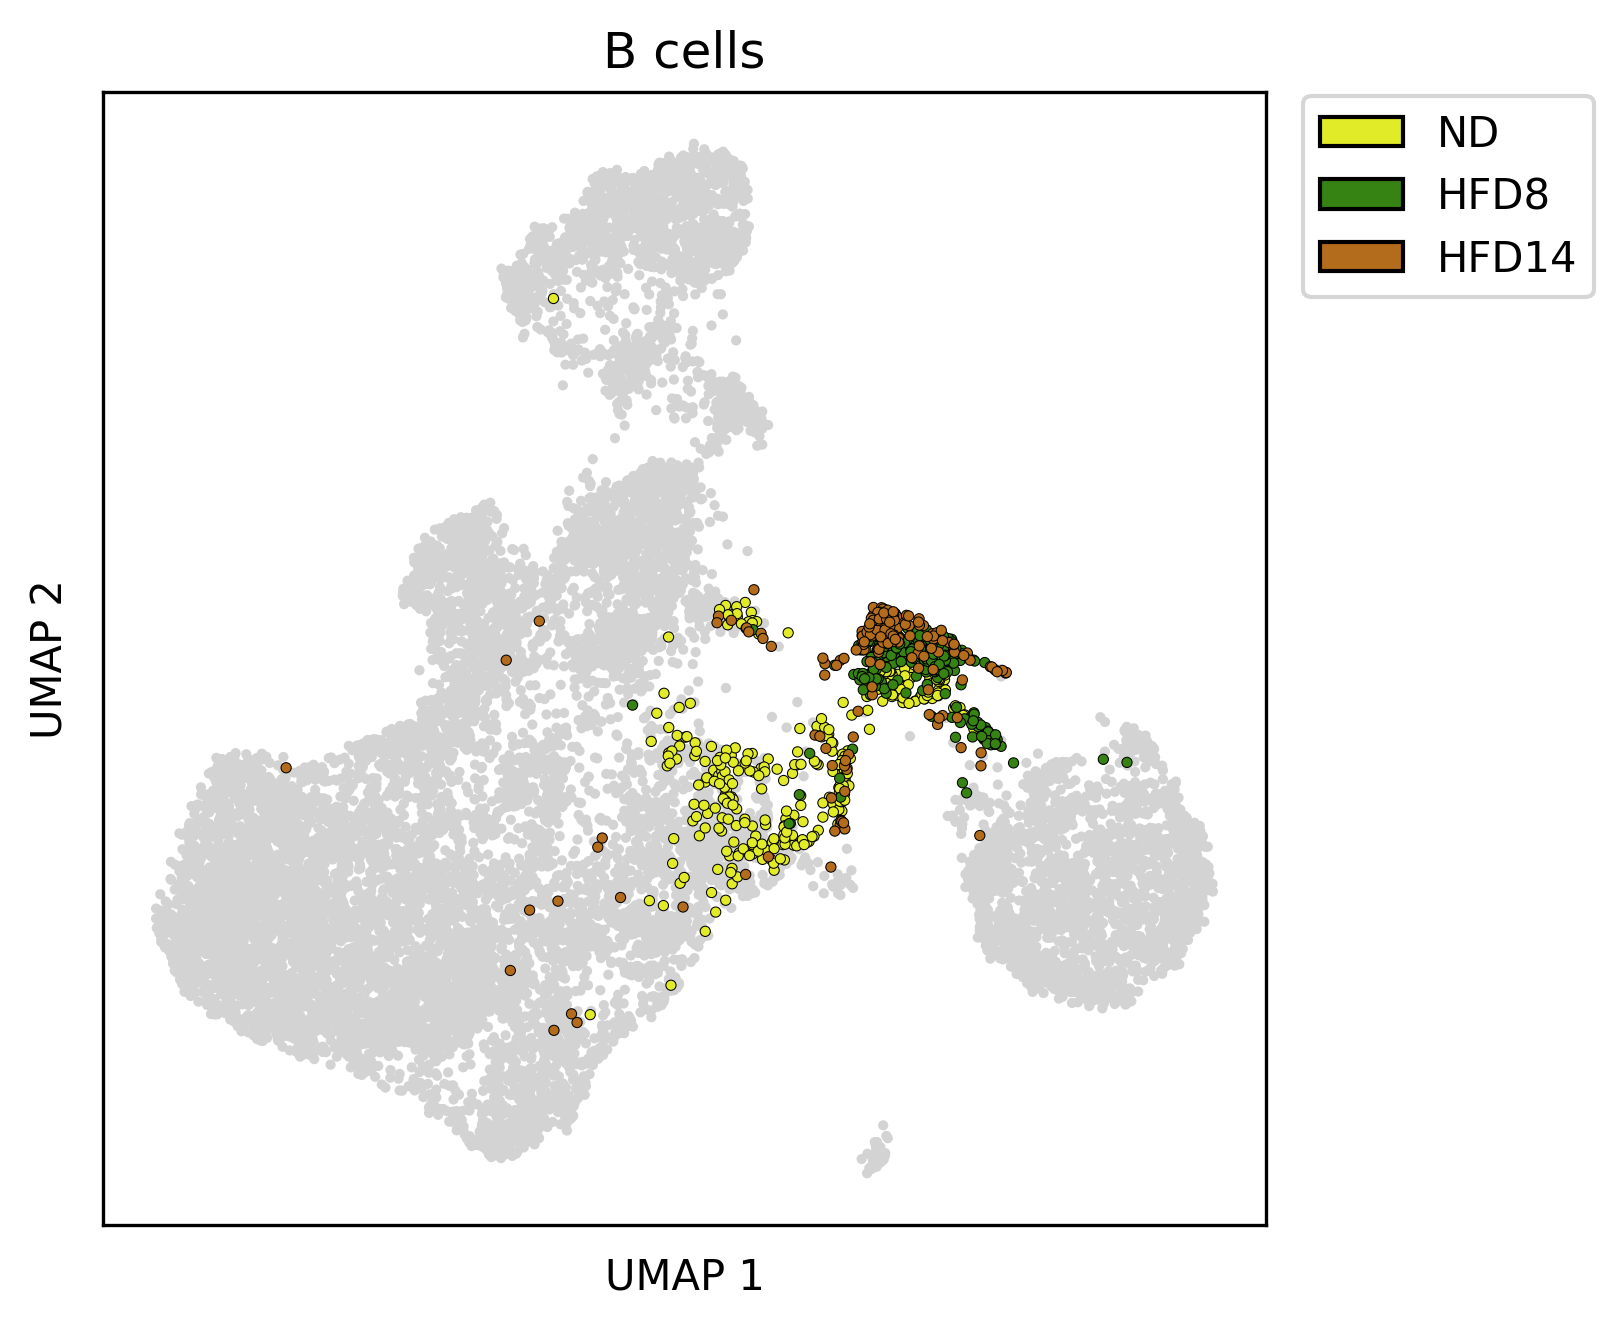

In [158]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['figure.facecolor'] = 'w'

print(ef['cellTypes'].unique())

query = 'B cells'
colors = ['#e1eb28', '#368212', '#b36c1b']
keyMap = dict(zip(ef['key'].unique(), colors))

keyHandles = []

for k, c in keyMap.items():        
    handle = mpatches.Patch(color=c, 
                            ec='k', 
                            label=k)
    keyHandles.append(handle)

pdf = ef.copy()
mask = pdf['cellTypes'] == query
keyColor = pdf['key'].map(keyMap)

plt.scatter(pdf['x'][mask], 
            pdf['y'][mask], 
            ec='k', 
            lw=0.25,
            c=keyColor[mask],
            zorder=2,
            s=6)

plt.scatter(pdf['x'][~mask], 
            pdf['y'][~mask], 
            ec='None', 
            lw=0.25,
            c='lightgrey',
            zorder=1,
            s=6)


plt.legend(handles=keyHandles, bbox_to_anchor=(1.3, 1.015))
plt.title(query)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

In [55]:

#     # print(df.head())
    
#     var = df.std(axis=0)
#     mask = var > minStd
#     print(f"{mask.sum()} ({mask.sum() / len(mask):.3f}) genes with std > {minStd}")
    
#     df = df[df.columns[np.where(mask)]]
    
    
#     # df = df[[mask.index.to_lis/t()]]
    
#     # print(df[['MRPL15']].head())
# #     
#     # sc.pp.highly_variable_genes(data, 
#     #                             min_mean=0.0125, 
#     #                             max_mean=3, 
#     #                             min_disp=0.5)
    
#     break
        
#     # get the run key
#     allKeys = list(data.obs.keys())
#     allKeys.remove('n_genes')
#     runKey = allKeys[0]
    
#     clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
#     embedding = data.obsm['X_umap']

#     # get coloring
#     c = ['k'] * len(embedding)
#     cellType = ['NULL'] * len(embedding)
#     handles = []
    
#     for ctype in ctypes:
#         mask = (cf['cellType'] == ctype) & (cf['key'] == key)
#         cids = cf[mask]['clusterId'].unique()
#         c = np.where(clusterIds.isin(cids), colordict[ctype], c)
#         cellType = np.where(clusterIds.isin(cids), ctype, cellType)
        
#     pdf = pd.DataFrame({'x' : embedding[:, 0], 
#                         'y' : embedding[:, 1]})
    
#     pdf['cellType'] = cellType
#     pdf['Color'] = c
#     pdf['clusterId'] = list(clusterIds)
    
#     pdf['key'] = key
    
#     dfList.append(pdf)
    
    
    
# pdf = pd.concat(dfList, ignore_index=True)


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 15, 15
# plt.rcParams['figure.facecolor'] = 'w'


# sns.scatterplot(data=pdf, 
#                 x='x', 
#                 y='y', 
#                 ec='k', 
#                 hue='cellType', 
#                 palette='Spectral')